In [1]:
import numpy as np

import scipy as sc
import scipy.io as scio # for loading .mat file
from scipy import linalg
from scipy.spatial import KDTree

from sklearn.decomposition import PCA as PCAdimReduc
from sklearn.feature_extraction import DictVectorizer

import networkx as nx

import pygmtools as pygm

import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

import cv2

import shapely

import svgpathtools
import drawsvg as draw

from bplustree import BPlusTree
from bplustree.serializer import Serializer
from bplustree.node import Node

import pickle

from xml.dom import minidom

import functools
from itertools import product, combinations
from typing import Optional, Tuple, List
from collections import Counter, defaultdict

import struct

import os, errno
import sys

import random

pygm.BACKEND = 'numpy' # set numpy as backend for pygmtools

# TOPOLOGY GRAPH / GEOMETRY EXTRACTION

In [2]:
from src.svg import *
from src.extraction import *
from src.database import *

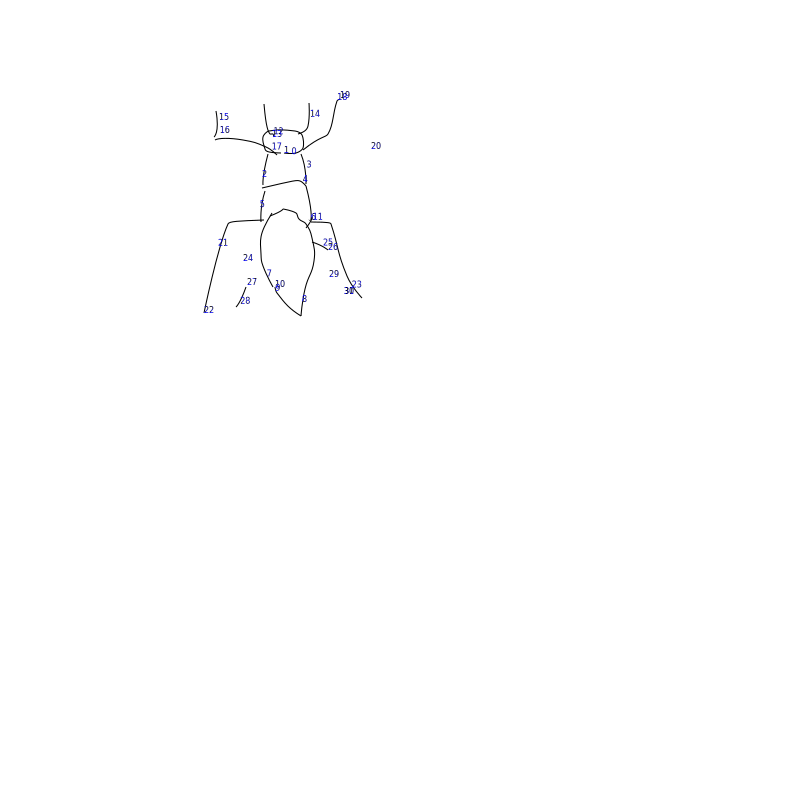

In [3]:
svg = load('assets/svg/ant/286.svg')
display(svg)

In [4]:
line_strings = get_line_strings(map(to_control_points, svg['paths']), step=15)

LINESTRING (270 150, 270 150, 270 150, 255 150, 255 150, 255 150, 255 150, 255 135, 255 135, 255 135, 255 135, 255 135, 255 135, 255 120, 255 120, 255 120, 255 120, 270 120, 270 120, 285 120, 285 120, 285 120, 300 120, 300 135, 300 135, 300 135, 300 135, 300 135, 300 135, 300 135, 285 150, 285 150, 285 150, 285 150, 270 150, 270 150)
<class 'shapely.geometry.linestring.LineString'>
141.21320343559643
0.0


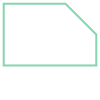

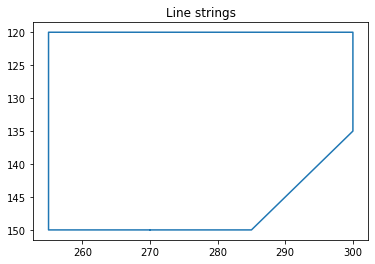

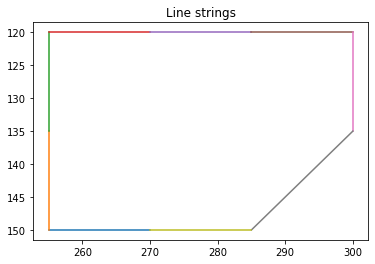

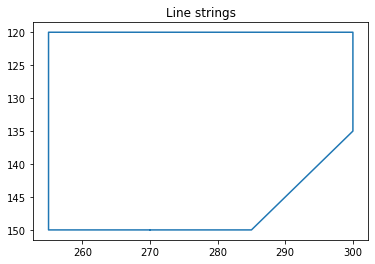

In [5]:
index = 0
ls = line_strings[index]

print(ls)
print(type(ls))
print(ls.length)

s, t = get_endpoints(ls)
print(s.distance(t))

plot_line_strings([ls])

segments = get_segments(ls)

# Plot segmented line string
plot_line_strings(segments)

# Plot closed line string
plot_line_strings([detect_approximate_polygon(ls)])

ls

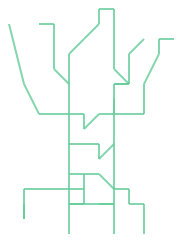

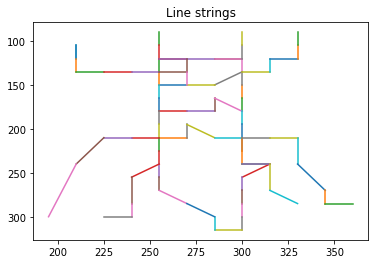

In [7]:
segments = []
for ls in line_strings:
    segments += get_segments(ls) 

# Plot segmented line string
plot_line_strings(segments)

shapely.MultiLineString(segments)

3


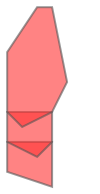

In [8]:
polygons = filter_polygons(get_polygons(line_strings), step=15)

print(len(polygons))

shapely.MultiPolygon(polygons)

### EXTRACTION

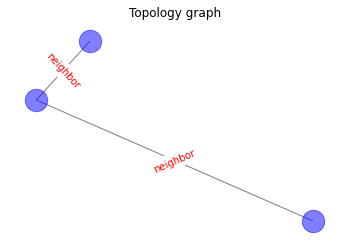

In [9]:
PATHS = map(to_control_points, svg['paths'])

G = extract_graph(PATHS, 'ant', step=15)
plot_graph(G)

G

# DATABASE

## Offline graph extraction

In [10]:
IMAGE_DIRECTORY = os.sep.join(['assets', 'svg'])

def load_svg_files(ext='svg'):
    """
    Returns an iterator that yields the image file paths and their labels.
    """    
    def get_label(path):
        return path.split(os.sep)[-1]
    
    files = []
    
    for r, _, f in os.walk(IMAGE_DIRECTORY):
        for file in f:
            if file.endswith(f'.{ext}'):
                label = get_label(r)
                file_path = os.path.join(r, file)
                
                files.append((file_path, label))
                
    return files


def load_svg_images(files):
    """
    Returns an iterator that yields the image data and their labels.
    """
    for f, l in files:
        print(f)
        yield load(f), l

def extract_graphs(images, step=20):
    """
    Extract all graphs from given images.
    """
    i = 0
    graphs = []
    for img, l in images:
        cp = map(to_control_points,img['paths'])
        
        try:
            graphs.append(extract_graph(cp, l, step=step))
        except StopIteration:
            print('drawing was too small')
        
        print(i)
        i += 1
        
    return graphs

In [11]:
# Extract graphs for each sketch in the dataset, offline processing step

# paths = load_svg_files()
# print(len(paths))

# images = load_svg_images(paths)

# graphs = extract_graphs(images, step=20)
# print(len(graphs))

In [12]:
import pickle

def dump_graphs(graphs, prefix=""):
    with open(prefix+'graphs.p', 'wb') as f:
        pickle.dump(graphs, f)
        
def load_graphs(prefix=""):
    with open(prefix+'graphs.p', 'rb') as f:
        return pickle.load(f)

In [35]:
# Dump the graphs to avoid this offline step later
# dump_graphs(graphs)

In [13]:
# Load graphs from disk
graphs = load_graphs()

len(graphs)

15564

## DIMENSIONALITY REDUCTION

max:  101
min:  0
99% percentile:  17.0


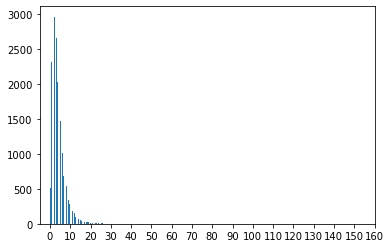

In [15]:
# Check the statistics for number of nodes

n = [len(g.nodes) for g in graphs]

fig = plt.figure()

# hist = np.histogram(n, bins=range(170))

plt.hist(n, bins=170) #, density=True)

plt.xticks(np.arange(0, 170, step=10))

print('max: ', max(n))
print('min: ', min(n))
print('99% percentile: ', np.percentile(n, 99))

max:  2028
min:  0
99% percentile:  47.0


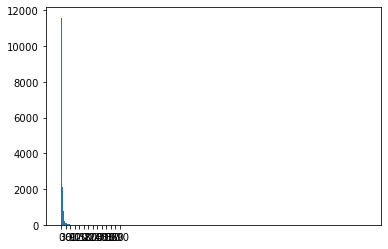

In [36]:
# Check the statistics for number of edges

e = [len(g.edges) for g in graphs]

# hist = np.histogram(e, bins=range(170))

fig = plt.figure()

plt.hist(e, bins=400) #, density=True)

plt.xticks(np.arange(0, 400, step=30))

print('max: ', max(e))
print('min: ', min(e))
print('99% percentile: ', np.percentile(e, 99))

In [37]:
# Check descriptor collisions for a given descriptor length

maximum = max(n)

print('100th percentile (maximum): ', maximum )

descriptors_max = [descriptor(g, N=maximum).tobytes() for g in graphs]

c_max = Counter(descriptors_max)

print('Unique descriptors: ', list(c_max.values()).count(1))

[(np.frombuffer(d, dtype=float), c) for d, c in c_max.most_common()]

100th percentile (maximum):  101
Unique descriptors:  3114


[(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  3715),
 (array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  2969),
 (array([1.41421356e+00, 1.41421356e+00, 2.77516890e-17, 0.000

In [18]:
# Check descriptor collisions for a given descriptor length

percent = 84

percentile = int(np.percentile(n,percent))

print(f'{percent}th percentile: ', percentile)

descriptors = [descriptor(g, N=percentile).tobytes() for g in graphs]

c_percentile = Counter(descriptors)

print('Unique descriptors: ', list(c_percentile.values()).count(1))

[(np.frombuffer(d, dtype=float), c) for d, c in c_percentile.most_common()]

84th percentile:  7
Unique descriptors:  3114


[(array([0., 0., 0., 0., 0., 0., 0.]), 3715),
 (array([1., 1., 0., 0., 0., 0., 0.]), 2969),
 (array([1.41421356e+00, 1.41421356e+00, 2.77516890e-17, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
  958),
 (array([2., 1., 1., 0., 0., 0., 0.]), 859),
 (array([1.41421356, 1.41421356, 0.        , 0.        , 0.        ,
         0.        , 0.        ]),
  540),
 (array([1.73205081e+00, 1.73205081e+00, 1.99837971e-16, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
  233),
 (array([3., 1., 1., 1., 0., 0., 0.]), 177),
 (array([2.17008649, 1.4811943 , 1.        , 0.31110782, 0.        ,
         0.        , 0.        ]),
  174),
 (array([1.61803399, 1.61803399, 0.61803399, 0.61803399, 0.        ,
         0.        , 0.        ]),
  149),
 (array([1., 1., 1., 1., 0., 0., 0.]), 132),
 (array([2.56155281e+00, 1.56155281e+00, 1.00000000e+00, 2.55566006e-17,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
  111),
 (array([1.732050

### Derive the frequencies of each label per descriptor

In [19]:
LABELS = ['airplane',
         'alarm clock',
         'angel',
         'ant',
         'apple',
         'arm',
         'armchair',
         'ashtray',
         'axe',
         'backpack',
         'banana',
         'barn',
         'baseball bat',
         'basket',
         'bathtub',
         'bear (animal)',
         'bed',
         'bee',
         'beer-mug',
         'bell',
         'bench',
         'bicycle',
         'binoculars',
         'blimp',
         'book',
         'bookshelf',
         'boomerang',
         'bottle opener',
         'bowl',
         'brain',
         'bread',
         'bridge',
         'bulldozer',
         'bus',
         'bush',
         'butterfly',
         'cabinet',
         'cactus',
         'cake',
         'calculator',
         'camel',
         'camera',
         'candle',
         'cannon',
         'canoe',
         'car (sedan)',
         'carrot',
         'castle',
         'cat',
         'cell phone',
         'chair',
         'chandelier',
         'church',
         'cigarette',
         'cloud',
         'comb',
         'computer monitor',
         'computer-mouse',
         'couch',
         'cow',
         'crab',
         'crane (machine)',
         'crocodile',
         'crown',
         'cup',
         'diamond',
         'dog',
         'dolphin',
         'donut',
         'door',
         'door handle',
         'dragon',
         'duck',
         'ear',
         'elephant',
         'envelope',
         'eye',
         'eyeglasses',
         'face',
         'fan',
         'feather',
         'fire hydrant',
         'fish',
         'flashlight',
         'floor lamp',
         'flower with stem',
         'flying bird',
         'flying saucer',
         'foot',
         'fork',
         'frog',
         'frying-pan',
         'giraffe',
         'grapes',
         'grenade',
         'guitar',
         'hamburger',
         'hammer',
         'hand',
         'harp',
         'hat',
         'head',
         'head-phones',
         'hedgehog',
         'helicopter',
         'helmet',
         'horse',
         'hot air balloon',
         'hot-dog',
         'hourglass',
         'house',
         'human-skeleton',
         'ice-cream-cone',
         'ipod',
         'kangaroo',
         'key',
         'keyboard',
         'knife',
         'ladder',
         'laptop',
         'leaf',
         'lightbulb',
         'lighter',
         'lion',
         'lobster',
         'loudspeaker',
         'mailbox',
         'megaphone',
         'mermaid',
         'microphone',
         'microscope',
         'monkey',
         'moon',
         'mosquito',
         'motorbike',
         'mouse (animal)',
         'mouth',
         'mug',
         'mushroom',
         'nose',
         'octopus',
         'owl',
         'palm tree',
         'panda',
         'paper clip',
         'parachute',
         'parking meter',
         'parrot',
         'pear',
         'pen',
         'penguin',
         'person sitting',
         'person walking',
         'piano',
         'pickup truck',
         'pig',
         'pigeon',
         'pineapple',
         'pipe (for smoking)',
         'pizza',
         'potted plant',
         'power outlet',
         'present',
         'pretzel',
         'pumpkin',
         'purse',
         'rabbit',
         'race car',
         'radio',
         'rainbow',
         'revolver',
         'rifle',
         'rollerblades',
         'rooster',
         'sailboat',
         'santa claus',
         'satellite',
         'satellite dish',
         'saxophone',
         'scissors',
         'scorpion',
         'screwdriver',
         'sea turtle',
         'seagull',
         'shark',
         'sheep',
         'ship',
         'shoe',
         'shovel',
         'skateboard',
         'skull',
         'skyscraper',
         'snail',
         'snake',
         'snowboard',
         'snowman',
         'socks',
         'space shuttle',
         'speed-boat',
         'spider',
         'sponge bob',
         'spoon',
         'squirrel',
         'standing bird',
         'stapler',
         'strawberry',
         'streetlight',
         'submarine',
         'suitcase',
         'sun',
         'suv',
         'swan',
         'sword',
         'syringe',
         't-shirt',
         'table',
         'tablelamp',
         'teacup',
         'teapot',
         'teddy-bear',
         'telephone',
         'tennis-racket',
         'tent',
         'tiger',
         'tire',
         'toilet',
         'tomato',
         'tooth',
         'toothbrush',
         'tractor',
         'traffic light',
         'train',
         'tree',
         'trombone',
         'trousers',
         'truck',
         'trumpet',
         'tv',
         'umbrella',
         'van',
         'vase',
         'violin',
         'walkie talkie',
         'wheel',
         'wheelbarrow',
         'windmill',
         'wine-bottle',
         'wineglass',
         'wrist-watch',
         'zebra'
         ]
len(LABELS)

250

In [20]:
# Get the weights of all categories 

# Filter graphs to a subset of labels if wanted
graphs = graphs

descriptors = map(lambda g: descriptor(g, N=7).tobytes(), graphs)

labels = map(lambda g: g.graph['label'], graphs)

res = defaultdict(list)
for key, val in zip(descriptors, labels):
    res[key].append(val)
    
counts = {k: Counter(v) for k, v in res.items()}
counts

{b"O\x92\x0cuN\xbe\x02@\x0f\x00\x8b@\x88\x04\xfd?\xff\xff\xff\xff\xff\xff\xef?\xb4m\xc7Y\xad\x1f\xde?\x99\xa9\xf2'\xd1\xf1f<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00": Counter({'airplane': 1,
          'backpack': 3,
          'bee': 2,
          'bell': 1,
          'bicycle': 1,
          'brain': 1,
          'bulldozer': 1,
          'castle': 1,
          'cat': 1,
          'frog': 1,
          'hand': 1,
          'head-phones': 1,
          'hedgehog': 1,
          'horse': 2,
          'hourglass': 1,
          'owl': 1,
          'pickup truck': 1,
          'rabbit': 2,
          'rainbow': 1,
          'satellite': 1,
          'scissors': 1,
          'shark': 1,
          'sheep': 1,
          'tiger': 1,
          'tractor': 2}),
 b'\xcd;\x7ff\x9e\xa0\xf6?\xcc;\x7ff\x9e\xa0\xf6?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00': Counter({'

In [21]:
# Vectorize these frequencies

to_index = {label: i for i, label in enumerate(LABELS)}

def get_frequencies(descriptor, counter):
    freq = np.zeros(len(LABELS), dtype=np.int8)
    
    for label, count in counter.items():
        i = to_index[label]
        freq[i] = count
        
    # freq /= np.sum(freq)
    return freq

FREQUENCIES = {d: get_frequencies(d, c).tobytes() for d, c in counts.items()}
FREQUENCIES  

{b"O\x92\x0cuN\xbe\x02@\x0f\x00\x8b@\x88\x04\xfd?\xff\xff\xff\xff\xff\xff\xef?\xb4m\xc7Y\xad\x1f\xde?\x99\xa9\xf2'\xd1\xf1f<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00": b'\x01\x00\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00\x02\x00\x01\x00\x01\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x01\x01\x00\x00\x02\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x01\x00\x00\x00\x00\x00\x00\x01\x00\x00\x01\x00\x00\x00\x00\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [22]:
# Dump frequencies

def dump_frequencies():
    with open('frequencies.p', 'wb') as f:
        pickle.dump(FREQUENCIES , f)

def load_frequencies():
    with open('frequencies.p', 'rb') as f:
        return pickle.load(f)
        
dump_frequencies()

In [23]:
# Check the frequencies for the zero descriptor
f = FREQUENCIES[bytes(8*7)]
np.frombuffer(f, dtype=np.int8)

array([22,  9,  5,  9, 39, 55,  5,  2, 16,  3, 21,  6, 39,  3, 11, 27,  9,
        2,  3, 12, 17,  9,  7, 17,  2,  2, 41,  7, 10,  7, 12, 12,  5,  4,
       39,  7,  7, 28,  2,  6, 43,  2, 10,  5, 15,  6, 34,  4, 12,  1, 12,
       21, 16, 20, 55, 23,  9,  7,  6, 21, 21, 11, 36, 16,  2,  6, 22, 33,
        4, 16, 14, 18, 26, 16, 22,  8,  4, 42, 27, 14, 17,  9, 18, 13, 36,
       14, 26,  6, 27, 21, 20,  6, 37, 19,  1, 18,  2, 12, 30,  1,  9, 20,
       36, 18,  8,  3, 25,  5,  3,  6,  6, 40,  5,  9, 30,  8, 11,  6,  4,
        2, 17, 20,  8,  6, 20,  5, 14, 12, 10, 24, 11, 13, 42, 20,  6, 29,
        4,  4, 17, 15,  5,  9, 25,  6,  5,  2,  5, 16, 51, 11, 13, 12, 19,
        4,  6, 23, 26,  7, 19,  4, 20, 11,  2,  0, 12,  4, 15,  9,  3, 25,
       13, 19, 11, 24, 17,  4,  6,  8, 17, 17, 25, 12,  6, 25, 32, 20, 11,
        9, 33, 29, 16, 10,  1, 33, 14,  1, 18,  4, 11, 23, 13, 22, 16, 19,
        7, 14, 46, 21, 12, 58,  1, 29, 32, 20, 54, 19, 23,  2,  6,  5,  2,
       14, 12,  8,  1,  2

## Database construction

### Disk B+-tree mapping descriptors to graph data

In [24]:
FREQUENCIES = load_frequencies()

In [25]:

    
# # Create iterator for all key/value pairs to be inserted into database
# iterator = sorted(FREQUENCIES.items(), key=lambda p: p[0])

# # Construct database for online use
# db = construct_database(iterator, N=7, value_size=250)

In [38]:
# Test query
db = open_database()

svg = load('assets/svg/ant/279.svg')

paths = map(to_control_points, svg['paths'])

query = extract_graph(paths, 'ant')
plot_graph(query)

key = descriptor(query, N=DESCRIPTOR_SIZE)
print(key)

dist = query_database(db, query)

db.close()

i = np.argmax(dist)
LABELS[i]

AssertionError: 

# GRAPH MATCHING

In [30]:
from src.matching import *

In [31]:
G = nx.tutte_graph()
G.graph['positions'] = nx.spring_layout(G)

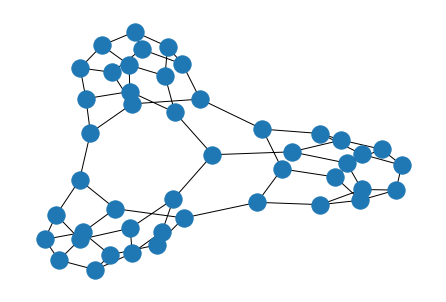

In [32]:
nx.draw(G, pos=G.graph['positions'])

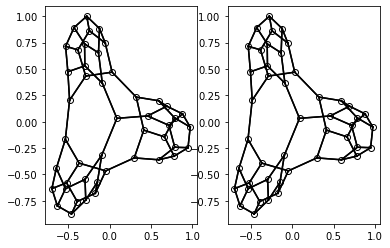

In [33]:
ax1 = plt.subplot(1, 2, 1)
plot_graph(G)

ax2 = plt.subplot(1, 2, 2)
plot_graph(G)

In [34]:
X = match(G, G)
print(X.shape)
X

(46, 46)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

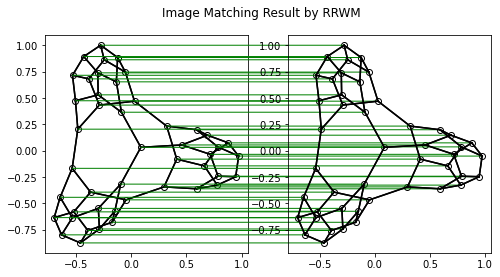

In [35]:
plot_mapping(X, G, G)